# Milestone 2

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from dateutil.relativedelta import relativedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN

##### Extracting quotes from politicians
In the following cell we load the provided metadata file, available [here](https://drive.google.com/drive/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0). This is used for obtaining a list of names of politicians, which we later use for filtering the QuoteBank dataset

In [ ]:
df_meta = pd.read_parquet('speaker_attributes.parquet')
df_meta = df_meta[df_meta['occupation'].notna()]

# The identifier for the occupation politician in Wikidata is Q82955
politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]
politicians = politicians[politicians['aliases'].notna()]
politicians = politicians[politicians['label'].notna()]

# Only consider US politicians
politicians = politicians[politicians['nationality'].notna()]
politicians = politicians[politicians.nationality.apply(lambda x: 'Q30' in x)]

# Make a combined list that contains both the aliases and the label names for the politicians
list_of_politicians = list(politicians.aliases.explode())
list_of_politicians += list(politicians.label)

We use the provided [Colab notebook](https://colab.research.google.com/drive/1NqLFrAWAzKxr2dAWHI7m6Ml3gWGF72cA?usp=sharing) for loading the QuoteBank dataset. This script creates a compressed file that is opened in the following cell

In [ ]:
df_reader = pd.read_json('quotes-2020-domains.json.bz2', lines=True, compression='bz2', chunksize=10000)

df_politicians = pd.concat([
    chunk[chunk['speaker'].isin(list_of_politicians)]
    for chunk in df_reader])


##### Save to disk
Since it takes quite some time to load and filter the data, let's save it to a compressed .csv file that we can se.

In [ ]:
compression_opts = dict(method='zip',archive_name='politicians.csv')  
df_politicians.to_csv('politicians.zip', index=False, compression=compression_opts)
compression_opts = dict(method='zip',archive_name='meta.csv')  
df_meta.to_csv('meta.zip', index=False, compression=compression_opts)

##### Read from disk

In [2]:
df_politicians = pd.read_csv("politicians.csv")
df_meta = pd.read_csv("meta.csv")

/Users/kalle/opt/anaconda3/envs/ada/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
nr_quotes = len(df_politicians)
print('There are {} quotes made by US politicians'.format(nr_quotes))
nr_speakers = len(df_politicians.speaker.unique())
print('There are {} speakers in the subset'.format(nr_speakers))

There are 392551 quotes made by US politicians
There are 3687 speakers in the subset


# Quote time correlation
##### Using quotes as signal
We retrieve all of Joe Biden's and Donald Trump's quotes for the year 2020 and the associated dates. We create a signal for each politician corresponding to the number of speeches recorded each week of the year. And finally we can visualise the correlation of the two signals but also the time lag between the two signals

In [3]:
df_politicians.date = pd.to_datetime(df_politicians.date)

In [4]:
def create_signal(name):
    """
    Create a signal of the number of quotes per week, made by a politician.
    Arguments:
        name: name of the politician
    """
    signal = np.zeros([53,])
    # We extract different ways to call him in the df
    aliases = list(df_meta[df_meta['label'] == name]['aliases'].values[0])
    # We extract all his quotes
    chunk = df_politicians[(df_politicians.speaker == name) | (df_politicians.speaker.isin(aliases))]
    # We ectract all the weeks of eachs quotes
    weeks = chunk.date.apply(lambda x: x.week).values
    # We create an histogram of number of quotes per weeks
    signal, _ = np.histogram(weeks, range(1, signal.shape[0]+2))
    return signal
signal_Donald_Trump = create_signal("Donald Trump")
signal_Joe_Biden = create_signal("Joe Biden")
signal_macron = create_signal("Emmanuel Macron")

##### Plot the results
Note that the reason for the signal becoming zero between week 10 and 20 is that the QuoteBank dataset was collected up until April 2020.

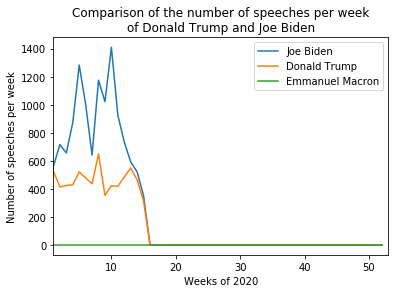

In [5]:
plt.plot(signal_Joe_Biden, label="Joe Biden")
plt.plot(signal_Donald_Trump, label="Donald Trump")
plt.plot(signal_macron, label="Emmanuel Macron")
plt.xlim(1,signal_Donald_Trump.shape[0])
plt.xlabel("Weeks of 2020")
plt.ylabel("Number of speeches per week")
plt.title("Comparison of the number of speeches per week\nof Donald Trump and Joe Biden")
plt.legend();

In [6]:
trump_biden_corr = np.correlate(signal_Donald_Trump/signal_Donald_Trump.sum(), signal_Joe_Biden/signal_Joe_Biden.sum())[0] # We anaylse the correlation between signals, normalized
trump_macron_corr = np.correlate(signal_Donald_Trump/signal_Donald_Trump.sum(), signal_macron/signal_macron.sum())[0]
biden_macron_corr = np.correlate(signal_Joe_Biden/signal_Joe_Biden.sum(), signal_macron/signal_macron.sum())[0]

print('Correlation between Trump and Biden: %.4f' % trump_biden_corr)
print('Correlation between Trump and Macron: %.4f' % trump_macron_corr)
print('Correlation between Biden and Macron: %.4f' % biden_macron_corr)

Correlation between Trump and Biden: 0.0647
Correlation between Trump and Macron: nan
Correlation between Biden and Macron: nan


/Users/clementnicolle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/clementnicolle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


We see that the correlation numbers are quite similar, escpecially for the ones including Joe Biden. In future work, we will have to come up with a test to see if the difference are statistically significant.

# Quote similarity
In this section we will demonstrate how we can compute quote similarity using Tfidf. This will be demonstrated using quotes from Donald Trump and Joe Biden.

##### Extract and save Trump and Biden quote 

In [32]:
chunk_Donald_Trump.to_csv("Trump_2020_v2.csv")
chunk_Joe_Biden.to_csv("Biden_2020_v2.csv")

##### Read the csv saved of Trump and Biden

In [33]:
Trump = pd.read_csv("Trump_2020_v2.csv")
Biden = pd.read_csv("Biden_2020_v2.csv")

##### Learn the vocabulary from the quotes of all politcians in the data set 

In [34]:
corpus = df_politicians['quotation'].to_list()
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=['english'])
vectorizer = vectorizer.fit(corpus)

###### Pick a random quote from Donald Trump

In [35]:
random = 25
ref_Trump = Trump.loc[random]
trump_quote = [ref_Trump.quotation]

###### Extract quotes of Joe Biden within the following month after the quote by Donald Trump

In [36]:
ref_date = datetime.strptime(ref_Trump.date, '%Y-%m-%d %H:%M:%S')
end_date = ref_date + relativedelta(months=1)
Biden.date = Biden.date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
Biden_target = Biden[Biden.date>ref_date]
Biden_target = Biden_target[Biden_target.date<end_date]
Biden_target = Biden_target[["date", "quotation"]].sort_values(ascending=True, by="date")

##### Vectorize the quotes using Tfidf

In [37]:
biden_quotes = Biden_target.quotation.to_list()

trump_vec = vectorizer.transform(trump_quote)
biden_vec = vectorizer.transform(biden_quotes)

##### Rank the quotes of Joe Biden according to the cosine similarity to the quote by Donald Trump and select the most similar

In [38]:
similar_index = np.argmax(cosine_similarity(trump_vec, biden_vec))
print("Cosine similarity: %.3f" % cosine_similarity(trump_vec, biden_vec[similar_index])[0][0])
print("-------")
similar_quote = biden_quotes[similar_index]
print("Quote by Donald Trump: ",trump_quote[0])
print("-------")
print("Quote by Joe Biden: ",biden_quotes[similar_index])

Cosine similarity: 0.243
-------
Quote by Donald Trump:  He does good at rockets, too, by the way. I never saw where the engines come down with no wings, no anything, and they're landing.
-------
Quote by Joe Biden:  I was there a long time, Joe, and I never saw anything like that,


# Quote similarity v2

In [5]:
quote = df_politicians[["speaker","quotation"]]

In [6]:
quote.head()

,speaker,quotation
0,Ben Carson,[ These ] actions will allow households who ha...
1,Dave Loebsack,a few of the candidates who will do better in ...
2,Julián Castro,A lot of Americans [ were ] upset that this wa...
3,Gavin Newsom,a manufacturer here in the state of California.
4,John Burke,"Although not a lubricant issue, tire wear is e..."


In [7]:
corpus = quote['quotation'].to_list()
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=['english'])
vectorizer = vectorizer.fit(corpus)

In [16]:
quote_vectorized = vectorizer.transform(quote.quotation)

In [27]:
quote_vectorized

<392551x59053 sparse matrix of type '<class 'numpy.float64'>'
	with 7396327 stored elements in Compressed Sparse Row format>

In [55]:
def count_non_null(my_list):
    my_list = my_list[0]
    s = 0
    for k in my_list :
        if (k!=0):
            s+=1
    return s        

##### Average number of non null component for each rows

In [81]:
n=0
L=np.arange(392551)
np.random.shuffle(L)
for k in range (10000):
    n+=count_non_null(quote_vectorized[L[k],:].todense().tolist())
n/10000

18.8945

In [84]:
nmf = NMF(2, random_state = 1).fit_transform(quote_vectorized)

In [96]:
from sklearn.cluster import KMeans, DBSCAN
kmeans = KMeans(n_clusters=8, random_state=0).fit_predict(nmf)

In [99]:
kmeans

array([4, 3, 3, ..., 6, 7, 0], dtype=int32)

In [100]:
nmf = NMF(18, random_state = 1).fit_transform(quote_vectorized)
kmeans = KMeans(n_clusters=8, random_state=0).fit_predict(nmf)
kmeans

array([6, 6, 6, ..., 4, 4, 7], dtype=int32)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


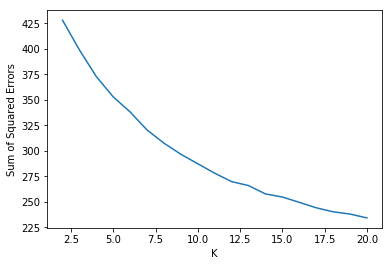

In [110]:
def plot_sse(features_X, start=2, end=21):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})
        print(k)
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(nmf)

2
3
4
5
6
7
8
9
10
11
12
13
14
15


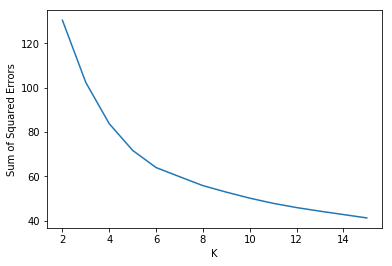

In [113]:
nmf = NMF(5, random_state = 1).fit_transform(quote_vectorized)
plot_sse(nmf, end=16)

In [117]:
kmeans = KMeans(n_clusters=6, random_state=0).fit_predict(nmf)
kmeans

array([1, 1, 1, ..., 5, 2, 0], dtype=int32)

In [118]:
quote["cluster"] = kmeans

/Users/clementnicolle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
quote.head()

,speaker,quotation,cluster
0,Ben Carson,[ These ] actions will allow households who ha...,1
1,Dave Loebsack,a few of the candidates who will do better in ...,1
2,Julián Castro,A lot of Americans [ were ] upset that this wa...,1
3,Gavin Newsom,a manufacturer here in the state of California.,1
4,John Burke,"Although not a lubricant issue, tire wear is e...",3


In [127]:
quote[quote["cluster"]==4]

,speaker,quotation,cluster
5,John Moore,And his own drama is that he's stuck in this c...,4
17,President Donald Trump,But think of it: A man leaks classified inform...,4
33,Mike Kelly,He's 21 or 22 years old so I'm not too worried...,4
37,Megyn Kelly,I actually don't happen to be one of those peo...,4
44,Nancy Pelosi,"I don't need any lesson from anybody, especial...",4
48,President Donald Trump,I hope it is not going to be a rigged deal bec...,4
49,President Donald Trump,I really believe it. And I'm going to work har...,4
50,Thomas Collins,I think we Catholics have taken the Mass for g...,4
63,Steve Bullock,"I'm just basically looking at it like, when I ...",4
68,Amy Klobuchar,"It is the first state but there's many to follow,",4


## Clustering concatenated quotes

In [8]:
quote['quote_conc']= quote.groupby(['speaker'])['quotation'].transform(lambda x: ','.join(x))
quotes_conc = quote.drop_duplicates(subset=['speaker'])[['speaker', 'quote_conc']]
quotes_conc

/var/folders/6y/wj5rbbbn4m3c5t1k5q50rrp40000gn/T/ipykernel_86424/911680192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quote['quote_conc']= quote.groupby(['speaker'])['quotation'].transform(lambda x: ','.join(x))


,speaker,quote_conc
0,Ben Carson,[ These ] actions will allow households who ha...
1,Dave Loebsack,a few of the candidates who will do better in ...
2,Julián Castro,A lot of Americans [ were ] upset that this wa...
3,Gavin Newsom,a manufacturer here in the state of California...
4,John Burke,"Although not a lubricant issue, tire wear is e..."
...,...,...
390456,Elizabeth Henderson,"As a farmer, I reject solutions like carbon ma..."
390778,George Bachrach,"This will be local, this will be transparent,"
391812,William Richardson,"Children need [ diapers ], toys and different ..."
391878,Jeh C. Johnson,my guess is his national security lawyers did ...


In [9]:
vectors = vectorizer.transform(quotes_conc['quote_conc'])
nmf = NMF(n_components=10, random_state=1).fit_transform(vectors)
distance_matrix = pairwise_distances(nmf, nmf, metric='cosine')

/Users/kalle/opt/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/kalle/opt/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [10]:
labels = DBSCAN(eps=0.04, min_samples=5, metric='precomputed',n_jobs=-1).fit_predict(distance_matrix)

In [11]:
set_of_clusters = set(labels)
unique_clusters = list(set_of_clusters)
unique_clusters

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1]

In [12]:
quotes_conc['cluster'] = labels

In [16]:
quotes_conc[quotes_conc['cluster'] == 0]

,speaker,quote_conc,cluster
0,Ben Carson,[ These ] actions will allow households who ha...,0
1,Dave Loebsack,a few of the candidates who will do better in ...,0
2,Julián Castro,A lot of Americans [ were ] upset that this wa...,0
3,Gavin Newsom,a manufacturer here in the state of California...,0
4,John Burke,"Although not a lubricant issue, tire wear is e...",0
...,...,...,...
375450,Mel Levine,We have now been able credibly to promise that...,0
379291,Sandra Day O'Connor,small and timid most of the year.,0
381425,Jim Edgar,"They could ask, she wouldn't have to do it,,It...",0
390456,Elizabeth Henderson,"As a farmer, I reject solutions like carbon ma...",0
